# Binary classification with logistic regression
Kudos to Zack Chase @ MXNet: The Straight Dope, for his excellent resource to support this analysis

In [73]:
import mxnet as mx 
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

##### Jupyter Notebook: display all results from a cell (not just last line)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#### Display the logistic (sigmoid) transformation

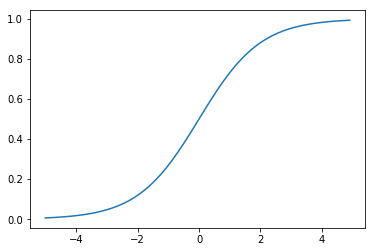

In [74]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))
    
x = nd.arange(-5, 5, .1)    
y = logistic(x)

plt.plot(x.asnumpy(),y.asnumpy())
plt.show()

## Data


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


pandas.core.frame.DataFrame

(768, 9)

dimension of diabetes data: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


Outcome
0    500
1    268
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


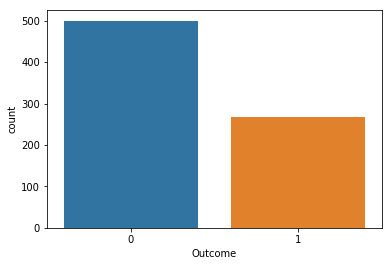

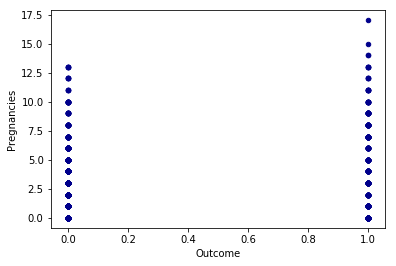

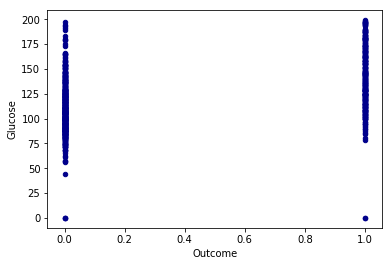

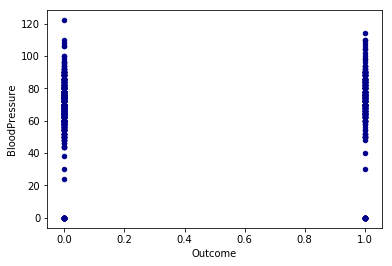

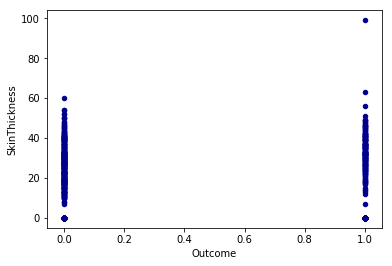

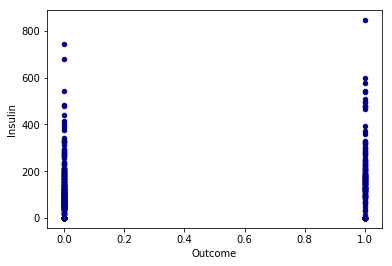

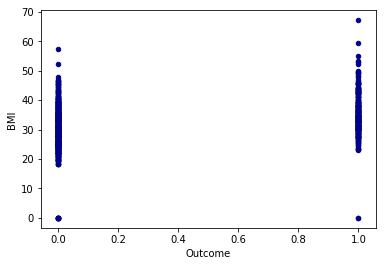

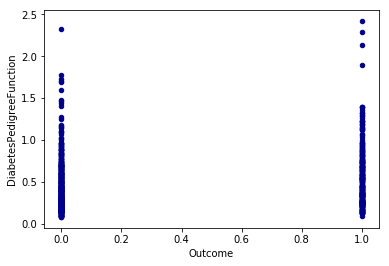

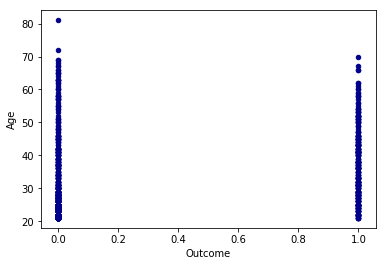

In [75]:
diabetes = pd.read_csv('diabetes.csv')

### Names of columns i.e. features & outcome
print(diabetes.columns)

type(diabetes)
diabetes.shape
###### The dataset consists of 768 observations, with 9 features each
print("dimension of diabetes data: {}".format(diabetes.shape))

diabetes.head()

diabetes.tail()

diabetes.groupby('Outcome').size()

sns.countplot(diabetes['Outcome'],label="Count")

diabetes.info()

predictors = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
for predictor in predictors:
    ax1 = diabetes.plot.scatter(x= 'Outcome',
        y=predictor,
        c='DarkBlue')
    

#### Specify the model / data context (GPU, CPU)

In [76]:
data_ctx = mx.cpu()
# Change this to `mx.gpu(0) if you would like to train on an NVIDIA GPU
model_ctx = mx.cpu()

### Split into training and test datasets
Split based on:  /n as this indicates end of each line of data. <br>
"**nd**" = creates an empty ndarray - we then populate this with the appropriate values from the original dataset.

In [77]:

from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest  = train_test_split(diabetes.loc[:, diabetes.columns != 'Outcome'], diabetes['Outcome'], stratify=diabetes['Outcome'], random_state=9)

In [78]:

Xtrain = mx.nd.array(Xtrain) 
Xtest = mx.nd.array(Xtest) 
Ytrain = mx.nd.array(Ytrain) 
Ytest = mx.nd.array(Ytest) 


#### Data type: mxnet.ndarray

In [79]:
type(Xtrain)
type(Ytrain)
type(Xtest)
type(Ytest)

mxnet.ndarray.ndarray.NDArray

mxnet.ndarray.ndarray.NDArray

mxnet.ndarray.ndarray.NDArray

mxnet.ndarray.ndarray.NDArray

#### Verify data arrays have the right shapes.

In [80]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(576, 8)
(576,)
(192, 8)
(192,)


#### Display the X features (predictors) in training & test data

In [81]:
Xtrain[0,:]
Xtrain


[  2.    174.     88.     37.    120.     44.5     0.646  24.   ]
<NDArray 8 @cpu(0)>


[[  2.    174.     88.    ...  44.5     0.646  24.   ]
 [  4.    123.     62.    ...  32.      0.226  35.   ]
 [  3.    170.     64.    ...  34.5     0.356  30.   ]
 ...
 [  1.     97.     66.    ...  23.2     0.487  22.   ]
 [  1.    117.     60.    ...  33.8     0.466  27.   ]
 [  4.    111.     72.    ...  37.1     1.39   56.   ]]
<NDArray 576x8 @cpu(0)>

In [82]:
Xtest[0,:]
Xtest


[  0.    125.     96.      0.      0.     22.5     0.262  21.   ]
<NDArray 8 @cpu(0)>


[[0.00e+00 1.25e+02 9.60e+01 ... 2.25e+01 2.62e-01 2.10e+01]
 [5.00e+00 1.09e+02 7.50e+01 ... 3.60e+01 5.46e-01 6.00e+01]
 [6.00e+00 1.95e+02 7.00e+01 ... 3.09e+01 3.28e-01 3.10e+01]
 ...
 [1.00e+00 1.06e+02 7.00e+01 ... 3.42e+01 1.42e-01 2.20e+01]
 [1.00e+00 1.16e+02 7.00e+01 ... 2.74e+01 2.04e-01 2.10e+01]
 [8.00e+00 1.54e+02 7.80e+01 ... 3.24e+01 4.43e-01 4.50e+01]]
<NDArray 192x8 @cpu(0)>

#### Display the Y column (outcome) in training & test data

In [83]:
Ytrain


[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0

In [84]:
Ytest


[0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
<NDArray 192 @cpu(0)>

#### Checking that train & test are from the same distribution

Check the fraction of positive examples in our training and test sets. 
This will give us one nice (necessary but insufficient) sanity check that our training and test data really are drawn from the same distribution.

In [85]:
print(Ytrain)

print(nd.sum(Ytrain)/len(Ytrain))
print(nd.sum(Ytest)/len(Ytest))


[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0

## Instantiate a dataloader

In [86]:
##### Load 8 samples each batch
batch_size = 8

##### 3 x options for the dataloader:
# 1: data = (Xtrain, Ytrain)
# 2: batch_size
# 3: shuffle

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, Ytrain),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, Ytest),
                                      batch_size=batch_size, shuffle=True)

In [87]:
type(train_data)
type(test_data)

mxnet.gluon.data.dataloader.DataLoader

mxnet.gluon.data.dataloader.DataLoader

## Define the model

In [88]:

net = gluon.nn.Dense(1)

net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Instantiate an optimizer
#### Stochastic gradient descent

In [89]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

## Define log loss - using the logistic function from earlier

In [90]:
def log_loss(output, y):
    
    ##### yhat = predicted probability
    yhat = logistic(output)
    
    ##### y = actual value of 'y'
    return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

In [91]:
epochs = 5
loss_sequence = []
num_examples = len(Xtrain)


## Run the model

In [92]:
##### How many times to run through the model (cycles / epochs)
for e in range(epochs):
##### Create the empty cumulative loss variable
    cumulative_loss = 0
##### Loop to cycle through "train_data": divide into "data" and "label"
    for i, (data, label) in enumerate(train_data):
##### Specify context for data & label
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
##### Run the model on the data batch & work out log_loss
        with autograd.record():
            output = net(data)
            print("Output: {}".format(output))
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Output: 
[[-433.67996]
 [ 424.7899 ]
 [-143.1463 ]
 [-365.04694]
 [ 379.51416]
 [-250.24384]
 [   4.90736]
 [-121.87697]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]

<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[

Epoch 2, loss: 0.0
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[na

<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Output: 
[

## Visualize the learning curve - i.e. epoch number V loss

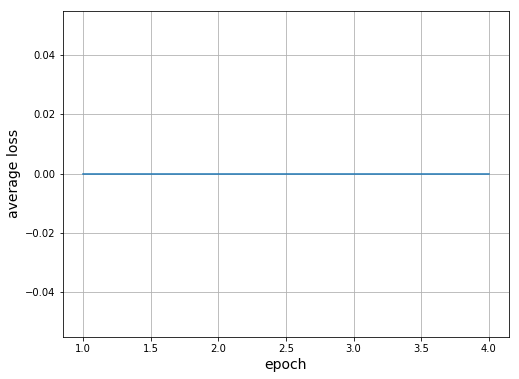

In [93]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

## Calculating accuracy

Predicted probabilities are often interpreted with a threshold value. This is used to classify samples (e.g. diabetes V not diabetes). <br>
The percentage accuracy score can be used alongside the negative log likelihood, to indicate how well the predicted probabilities agree with the observed labels.


In [94]:
num_correct = 0.0
num_total = len(Xtest)
counter = 0
counter_2 = 0

for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    ##### net = gluon.nn.Dense(1)
    output = net(data)
    ##### prediction = (nd.sign(output) + 1) / 2
    prediction =  nd.sign(output)
    counter   += i
    counter_2 += i
    
    print("Output: {}".format(output))
    print("Prediction: {}".format(prediction))
    print("Label: {}".format(label))
    print("Counter: {}".format(counter))
    print("Counter_2: {}".format(counter_2))


'''
    num_correct += nd.sum(prediction == label)
    print("num_correct {}, {}".format(num_correct, i))
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))
'''

print("num_total {}".format(num_total))
print("num_correct {}".format(num_correct))


Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Prediction: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
<NDArray 8x1 @cpu(0)>
Label: 
[0. 0. 1. 1. 1. 0. 0. 1.]
<NDArray 8 @cpu(0)>
Counter: 0
Counter_2: 0
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Prediction: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
<NDArray 8x1 @cpu(0)>
Label: 
[1. 0. 0. 1. 0. 1. 0. 1.]
<NDArray 8 @cpu(0)>
Counter: 1
Counter_2: 1
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Prediction: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
<NDArray 8x1 @cpu(0)>
Label: 
[0. 0. 0. 1. 0. 1. 1. 0.]
<NDArray 8 @cpu(0)>
Counter: 3
Counter_2: 3
Output: 
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
<NDArray 8x1 @cpu(0)>
Prediction: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
<NDArray 8x1 @cpu(0)>
Label: 
[0. 1. 0. 0. 0. 0. 1. 0.]
<NDArray 8 @cpu(0)>
Counter: 6
Counter_2: 6


'\n    num_correct += nd.sum(prediction == label)\n    print("num_correct {}, {}".format(num_correct, i))\nprint("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))\n'

num_total 192
num_correct 0.0


**A naive classifier would predict that everyone had the majority class (e.g. classify everyone as diabetic). This classifier would achieve an accuracy of roughly 75%.
By contrast, our classifier gets an accuracy of .84 (results may vary a small amount on each run owing to random initializations and random sampling of the batches). **